# Import Libraries and Load Data

In [57]:
import pandas as pd
import numpy as np  
from scipy import stats

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization defaults
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# non-linear models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# linear models
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

# model helpers
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# scoring metric
from sklearn.metrics import mean_absolute_error

# custom function data report
from data_report import *

#### Load training data

In [147]:
freq_train = pd.read_csv(r".\data\train_data\frequency_domain_features_train.csv")
hr_train = pd.read_csv(r".\data\train_data\heart_rate_non_linear_features_train.csv")
time_train = pd.read_csv(r".\data\train_data\time_domain_features_train.csv")

#### Load test data

In [150]:
# import test datasets
freq_test = pd.read_csv(r".\data\test_data\frequency_domain_features_test.csv")
hr_test = pd.read_csv(r".\data\test_data\heart_rate_non_linear_features_test.csv")
time_test = pd.read_csv(r".\data\test_data\time_domain_features_test.csv")

#### Merge the datasets 

In [151]:
train = pd.merge(
    pd.merge(freq_train, hr_train, left_on='uuid', right_on='uuid'), 
    time_train, left_on='uuid', right_on='uuid'
)

test = pd.merge(
    pd.merge(freq_test, hr_test, left_on='uuid', right_on='uuid'),
    time_test, left_on='uuid', right_on='uuid'
)

# EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 37 columns):
uuid                 369289 non-null object
VLF                  369289 non-null float64
VLF_PCT              369289 non-null float64
LF                   369289 non-null float64
LF_PCT               369289 non-null float64
LF_NU                369289 non-null float64
HF                   369289 non-null float64
HF_PCT               369289 non-null float64
HF_NU                369289 non-null float64
TP                   369289 non-null float64
LF_HF                369289 non-null float64
HF_LF                369289 non-null float64
SD1                  369289 non-null float64
SD2                  369289 non-null float64
sampen               369289 non-null float64
higuci               369289 non-null float64
datasetId            369289 non-null int64
condition            369289 non-null object
MEAN_RR              369289 non-null float64
MEDIAN_RR            369289 non-null f

All of the features are numeric save for the **uuid** which is the patient identifier and **condition**.

In [152]:
train.condition.value_counts()

no stress        200082
interruption     105150
time pressure     64057
Name: condition, dtype: int64

In [153]:
test.condition.value_counts()

no stress        22158
interruption     11782
time pressure     7093
Name: condition, dtype: int64

One-hot encoding seems appropriate for this data. Before we proceed, let's visualize the distribution of HR with respect the diffrent levels of this categorical variable.

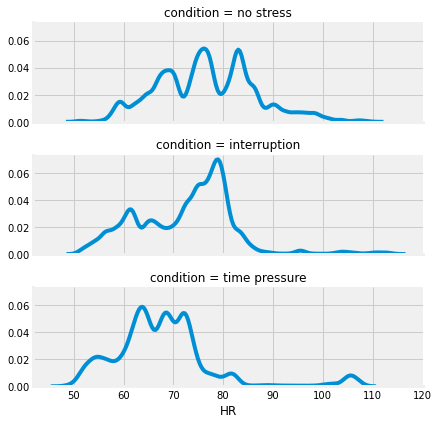

In [166]:
h = sns.FacetGrid(train, row = 'condition',sharex=True, height=2, aspect=3)
h.map(sns.kdeplot, 'HR');
h.add_legend();

There are some interesting multimodal behavior going in across these distributions. Perhaps we can explore this further.

In [191]:
onehot_condition_train = pd.get_dummies(train.condition, drop_first=True)
onehot_condition_test = pd.get_dummies(test.condition, drop_first=True)

# add onehot to train and test and drop condition column
train = pd.concat([train,onehot_condition_train], axis=1).drop(columns=['condition'])
test = pd.concat([test,onehot_condition_test], axis=1).drop(columns=['condition'])

#### Assemble the data quality report

In [17]:
data_report(train.loc[:,'VLF':])

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew,kurtosis
VLF,369289.0,0.0,369289,2199.580170,1815.773422,159.480176,1001.189280,1.667903e+03,2654.121052,12617.977191,1.960735,4.493563
VLF_PCT,369289.0,0.0,369289,64.289242,16.774844,19.031219,52.909877,6.635024e+01,76.825032,97.738848,-0.410836,-0.520971
LF,369289.0,0.0,369289,946.530252,574.171780,90.048557,545.449386,7.827163e+02,1201.432256,3291.548112,1.349076,1.739223
LF_PCT,369289.0,0.0,369289,34.095182,16.040290,2.165119,22.305936,3.204703e+01,44.647115,77.928847,0.425164,-0.489052
LF_NU,369289.0,0.0,369289,95.566718,4.123365,69.879083,93.645734,9.664314e+01,98.771946,99.987175,-1.645603,3.852707
HF,369289.0,0.0,369289,39.245603,45.398869,0.061783,10.720312,2.484194e+01,45.272368,364.486936,2.476530,7.961637
HF_PCT,369289.0,0.0,369289,1.615576,1.761073,0.002150,0.346803,1.039513e+00,2.245115,13.095664,2.021882,5.517449
HF_NU,369289.0,0.0,369289,4.433282,4.123365,0.012825,1.228054,3.356860e+00,6.354266,30.120917,1.645603,3.852707
TP,369289.0,0.0,369289,3185.356025,1923.227187,377.692795,1828.147788,2.796857e+03,4052.260157,13390.684098,1.452435,2.813712
LF_HF,369289.0,0.0,369289,115.977200,360.855129,2.319952,14.737458,2.878975e+01,80.429614,7796.443096,9.781091,133.475215


- No missing values
- **datasetid** can be dropped
- several features are exhibiting high levels of skewness



In [19]:
# dropping datasetid
train.drop(columns=['datasetId'], inplace=True)

As a rule of thumb skewed data whose ratio of the maximum to the minimum value is greater than 20 exhibits significant skewness. We should apply a transformation to these variables where we can. These features are listed below:

In [20]:
max_min_ratio = train.describe().T['max']/train.describe().T['min']

need_to_transform = max_min_ratio[max_min_ratio >= 20].index.values

print(need_to_transform)

['VLF' 'LF' 'LF_PCT' 'HF' 'HF_PCT' 'HF_NU' 'TP' 'LF_HF' 'HF_LF' 'SD2'
 'SDRR' 'SDRR_RMSSD' 'pNN25' 'pNN50' 'no stress' 'time pressure']


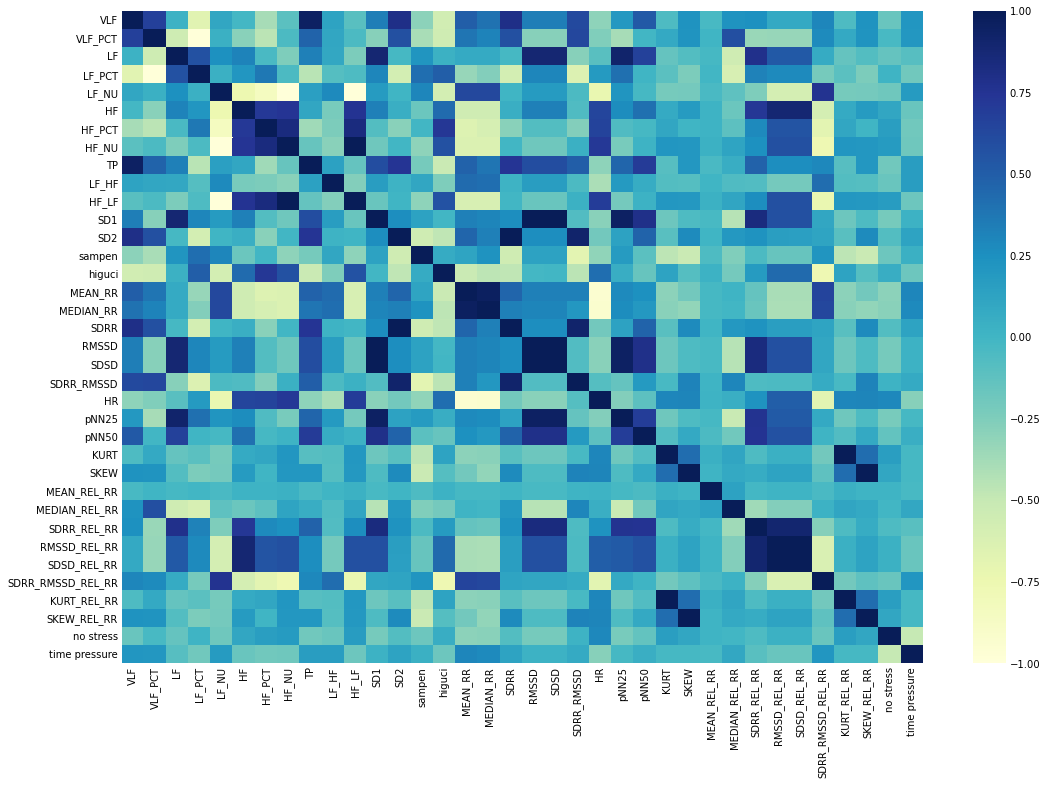

In [34]:
corr = train.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='YlGnBu');

Sorted correlations with respect to HR

In [102]:
corr.HR.sort_values()

MEAN_RR             -0.944552
MEDIAN_RR           -0.929640
LF_NU               -0.724268
SDRR_RMSSD_REL_RR   -0.675554
LF_HF               -0.404740
sampen              -0.307587
VLF                 -0.304568
TP                  -0.301295
RMSSD               -0.284871
SD1                 -0.284863
SDSD                -0.284863
time pressure       -0.273782
pNN25               -0.262903
VLF_PCT             -0.254543
SDRR                -0.202327
SD2                 -0.202003
pNN50               -0.114896
LF                  -0.097228
SDRR_RMSSD          -0.084332
MEAN_REL_RR          0.017776
MEDIAN_REL_RR        0.054649
LF_PCT               0.194131
SDRR_REL_RR          0.234557
no stress            0.295296
KURT_REL_RR          0.303671
KURT                 0.303671
SKEW_REL_RR          0.306402
SKEW                 0.306402
higuci               0.420932
RMSSD_REL_RR         0.499867
SDSD_REL_RR          0.499867
HF                   0.647427
HF_PCT               0.656421
HF_LF     

In [169]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(np.array(train.MEAN_RR).reshape(-1,1))

In [96]:
# Initialize Linear Regression Model
lin_reg = LinearRegression()

# Fit model on the polynomial feature X_poly
lin_reg.fit(mean_RR_poly,train.HR)

# predict
predicted_HR = lin_reg.predict(mean_RR_poly)

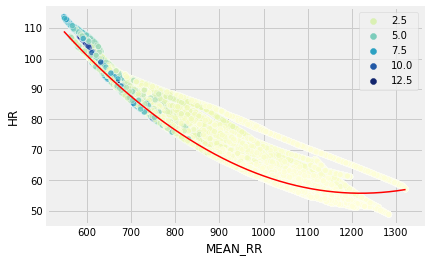

In [171]:
sns.scatterplot(data=train, x='MEAN_RR', y='HR', hue='HF_PCT', palette= 'YlGnBu', alpha=0.7);
sns.lineplot(x=train.MEAN_RR, y=predicted_HR, linewidth=1.5, color='red');

Most of the higher HRs are characterized by larger values of **HF_PCT**. Later I will add the polynomial terms to the train set and see if we get a boost in performance.

# Preprocessing

#### Actions Items:
1. Transformations (box-cox, log, etc)
2. Feature Selection 
    - Filter method using Pearson correlation
    - Wrapper methods like forward search. Sklearn has a [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) library we can use 

In [144]:
# create input feature array
X = train.drop(columns=['HR','uuid'])

# create prediction labels
y = train['HR']

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Random Forest

In [145]:
# Initialize model
rf_reg = RandomForestRegressor(random_state=1, n_jobs=-1)

# fit 
rf_reg.fit(X_train, y_train)

# predict
y_pred = rf_reg.predict(X_test)


0.00794324170364555

In [172]:
# MAE
print("MAE = {}".format(mean_absolute_error(y_pred, y_test)))

MAE = 0.00794324170364555


This result is cause for optimism since we have not performed any feature selection nor preprocessing, and yet we are just falling short of the best models submitted so far which are scoring around 0.0014. 

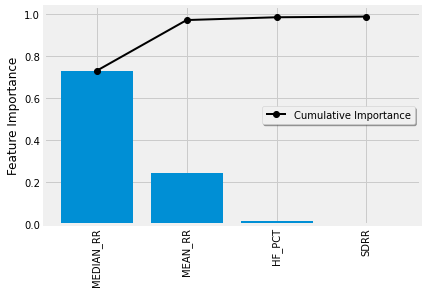

In [146]:
# feature importances from random forest model
importances = rf_reg.feature_importances_

# index of greatest to least features importances
sorted_index = np.argsort(importances)[::-1][:4]
x = range(len(sorted_index))

# create labels
# feature_names = poly_features.get_feature_names(X.columns)
feature_names = X.columns
labels = np.array(feature_names)[sorted_index]

# compute cumulative importances
cum_importance = np.cumsum(importances[sorted_index])

plt.bar(x, importances[sorted_index], tick_label=labels)
plt.plot(cum_importance, c='black', linewidth=2, marker='o', label='Cumulative Importance')
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.legend(shadow=True, loc='center right')
plt.show()

**MEDIAN_RR** and **MEAN_RR** are the most important features wrt the random forest model. These features are highly correlated

In [175]:
corr['MEDIAN_RR']['MEAN_RR']

0.9609491736076226

Let's add in the polynomial features and see what we get in terms of better performance

In [185]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(train[['MEDIAN_RR','HF_PCT']])

In [187]:
poly_cols = poly_features.get_feature_names(train[['MEDIAN_RR','HF_PCT']].columns)
poly_df = pd.DataFrame(X_poly, columns=poly_cols)

In [192]:
train_poly = pd.concat([train,poly_df], axis=1)

In [193]:
# create input feature array
X = train_poly.drop(columns=['HR','uuid'])

# create prediction labels
y = train_poly['HR']

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [194]:
# Initialize model
rf_reg = RandomForestRegressor(random_state=1, n_jobs=-1)

# fit 
rf_reg.fit(X_train, y_train)

# predict
y_pred = rf_reg.predict(X_test)

In [195]:
# MAE
print("MAE w/ poly features = {}".format(mean_absolute_error(y_pred, y_test)))

MAE w/ poly features = 0.007928898771914574


This didn't buy us much.

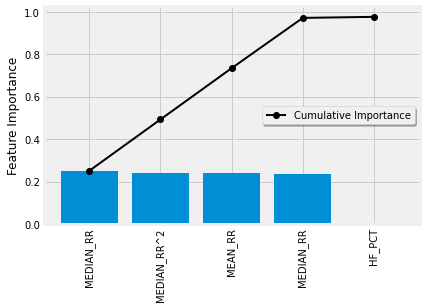

In [197]:
# feature importances from random forest model
importances = rf_reg.feature_importances_

# index of greatest to least features importances
sorted_index = np.argsort(importances)[::-1][:5]
x = range(len(sorted_index))

# create labels
# feature_names = poly_features.get_feature_names(X.columns)
feature_names = X.columns
labels = np.array(feature_names)[sorted_index]

# compute cumulative importances
cum_importance = np.cumsum(importances[sorted_index])

plt.bar(x, importances[sorted_index], tick_label=labels)
plt.plot(cum_importance, c='black', linewidth=2, marker='o', label='Cumulative Importance')
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.legend(shadow=True, loc='center right')
plt.show()